In [3]:
%matplotlib inline

import torch
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle as pkl

In [2]:
num_workers = 0

# Chia mẫu thành các mini-batch
batch_size = 64

# transform dữ liệu sang kiểu tensor
transform = transforms.ToTensor()

# Số viết tay
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

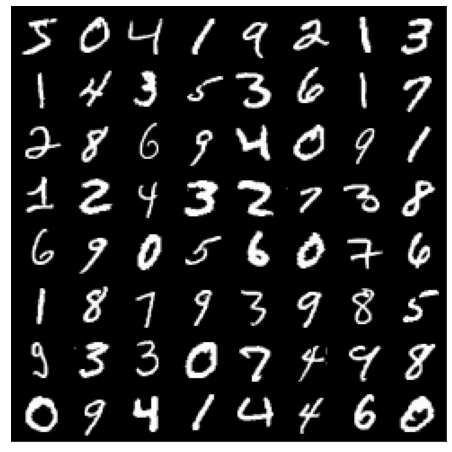

In [4]:
# Hiển thị một số hình ảnh từ MNIST
dataiter = iter(train_loader)
images, labels = dataiter.next()

images = torchvision.utils.make_grid(images)

numpyimgs = images.numpy()

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(numpyimgs, (1,2,0)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # xác định các layer ẩn
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_size),
        )
        
    def forward(self, input):
        input = input.view(-1, 28*28)
        out = self.model(input)

        return out

In [6]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, output_size),
        )

    def forward(self, input):
        # apply tanh
        out = torch.tanh(self.model(input))

        return out

In [7]:
# Tham số mạng Discriminator

# ảnh đầu vào 28*28
input_size = 784
# kích thước đầu ra mạng Discriminator
d_output_size = 1
# kích thước layer ẩn cuối cùng
d_hidden_size = 32

# Tham số mạng Generator

# Kích thước vector nhiễu đưa vào Generator
z_size = 100
# Kích thước ảnh đẩu ra (generated image)
g_output_size = 784
# Kích thước layer ẩn cuối
g_hidden_size = 32

In [8]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=12

In [9]:
# Tính toán mất mát
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
        
    # Tính real loss với hàm Sigmoid và BCE
    criterion = nn.BCEWithLogitsLoss()
  
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size) 
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [10]:
# Tối ưu
learing_rate = 1e-3

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), learing_rate)
g_optimizer = optim.Adam(G.parameters(), learing_rate)

In [11]:
# Epochs training
num_epochs = 200

# Lưu lại kết quả của hàm mất mát và các mẫu sinh
samples = []
losses = []

print_every = 400

# vector nhiều
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Training
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Rescale ảnh cho Leaky ReLU
        real_images = real_images*2 - 1  #[0,1) thành [-1, 1)
        
        # ============================================
        #            Huấn luyện cho DISCRIMINATOR
        # ============================================
        
        # set d_optimizer = 0 chuẩn bị cho lan truyền ngược
        d_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh thực

        # Tính mất mát của discriminator với ảnh thực 
        # smooth nhãn thực
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Huấn luyện với ảnh giả
        
        # Sinh ảnh giả
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Tính mất mát của discriminator với ảnh giả     
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Cộng kết quả 2 loss, tối ưu và cập nhật hệ số
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            Huấn luyện GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh sinh vầ nhãn ngược
        
        # Tạo ảnh giả
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Tính mất mát của discriminator trên ảnh giả nhưng sử dụng label ngược
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # sử  dụng real_loss cho label ngược
        
        # Lan truyền ngược, tối ưu, cập nhật
        g_loss.backward()
        g_optimizer.step()

        # Print số liệu mất mát
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Sau mỗi epoch
    # bổ sung discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # tạo và lưu mẫu sinh
    G.eval() # eval mode
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # train lại mô hình


# Lưu lại tất cả các mẫu đã sinh
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  200] | d_loss: 1.3727 | g_loss: 0.7563
Epoch [    1/  200] | d_loss: 0.5750 | g_loss: 5.0570
Epoch [    1/  200] | d_loss: 1.1645 | g_loss: 0.9694
Epoch [    2/  200] | d_loss: 1.5798 | g_loss: 0.4618
Epoch [    2/  200] | d_loss: 0.8895 | g_loss: 1.7194
Epoch [    2/  200] | d_loss: 0.6904 | g_loss: 3.0864
Epoch [    3/  200] | d_loss: 0.6482 | g_loss: 5.0037
Epoch [    3/  200] | d_loss: 0.6142 | g_loss: 3.0749
Epoch [    3/  200] | d_loss: 1.0481 | g_loss: 2.4587
Epoch [    4/  200] | d_loss: 0.9578 | g_loss: 3.1571
Epoch [    4/  200] | d_loss: 1.0528 | g_loss: 1.5390
Epoch [    4/  200] | d_loss: 1.0233 | g_loss: 1.1570
Epoch [    5/  200] | d_loss: 1.0616 | g_loss: 1.7166
Epoch [    5/  200] | d_loss: 1.1816 | g_loss: 1.2714
Epoch [    5/  200] | d_loss: 1.0120 | g_loss: 1.5952
Epoch [    6/  200] | d_loss: 1.0498 | g_loss: 1.3122
Epoch [    6/  200] | d_loss: 1.0784 | g_loss: 1.3513
Epoch [    6/  200] | d_loss: 0.9738 | g_loss: 1.7332
Epoch [    7/  200] | d_loss

Epoch [   51/  200] | d_loss: 1.3363 | g_loss: 0.8515
Epoch [   52/  200] | d_loss: 1.3061 | g_loss: 1.0219
Epoch [   52/  200] | d_loss: 1.1880 | g_loss: 1.0231
Epoch [   52/  200] | d_loss: 1.3587 | g_loss: 1.0585
Epoch [   53/  200] | d_loss: 1.2088 | g_loss: 1.1677
Epoch [   53/  200] | d_loss: 1.2261 | g_loss: 0.9242
Epoch [   53/  200] | d_loss: 1.2452 | g_loss: 1.0742
Epoch [   54/  200] | d_loss: 1.2176 | g_loss: 1.0810
Epoch [   54/  200] | d_loss: 1.2917 | g_loss: 0.9886
Epoch [   54/  200] | d_loss: 1.3179 | g_loss: 1.0930
Epoch [   55/  200] | d_loss: 1.3372 | g_loss: 1.1701
Epoch [   55/  200] | d_loss: 1.2820 | g_loss: 0.8661
Epoch [   55/  200] | d_loss: 1.3213 | g_loss: 0.8718
Epoch [   56/  200] | d_loss: 1.3148 | g_loss: 0.8959
Epoch [   56/  200] | d_loss: 1.1804 | g_loss: 1.1235
Epoch [   56/  200] | d_loss: 1.1600 | g_loss: 1.1080
Epoch [   57/  200] | d_loss: 1.2215 | g_loss: 1.3007
Epoch [   57/  200] | d_loss: 1.2997 | g_loss: 0.8581
Epoch [   57/  200] | d_loss

Epoch [  102/  200] | d_loss: 1.3200 | g_loss: 0.9504
Epoch [  102/  200] | d_loss: 1.3714 | g_loss: 0.9931
Epoch [  103/  200] | d_loss: 1.2912 | g_loss: 1.0718
Epoch [  103/  200] | d_loss: 1.1970 | g_loss: 1.0628
Epoch [  103/  200] | d_loss: 1.3713 | g_loss: 1.0000
Epoch [  104/  200] | d_loss: 1.2177 | g_loss: 1.1366
Epoch [  104/  200] | d_loss: 1.2373 | g_loss: 1.1687
Epoch [  104/  200] | d_loss: 1.3521 | g_loss: 0.9960
Epoch [  105/  200] | d_loss: 1.3873 | g_loss: 0.9863
Epoch [  105/  200] | d_loss: 1.3326 | g_loss: 0.9291
Epoch [  105/  200] | d_loss: 1.4272 | g_loss: 1.0360
Epoch [  106/  200] | d_loss: 1.3768 | g_loss: 1.0591
Epoch [  106/  200] | d_loss: 1.2157 | g_loss: 1.0744
Epoch [  106/  200] | d_loss: 1.3900 | g_loss: 1.0205
Epoch [  107/  200] | d_loss: 1.2657 | g_loss: 1.2677
Epoch [  107/  200] | d_loss: 1.2575 | g_loss: 1.0565
Epoch [  107/  200] | d_loss: 1.4459 | g_loss: 0.9784
Epoch [  108/  200] | d_loss: 1.3657 | g_loss: 0.8702
Epoch [  108/  200] | d_loss

Epoch [  153/  200] | d_loss: 1.3078 | g_loss: 1.1983
Epoch [  153/  200] | d_loss: 1.2422 | g_loss: 0.9890
Epoch [  153/  200] | d_loss: 1.2805 | g_loss: 0.9280
Epoch [  154/  200] | d_loss: 1.2722 | g_loss: 1.0729
Epoch [  154/  200] | d_loss: 1.2731 | g_loss: 1.4753
Epoch [  154/  200] | d_loss: 1.3861 | g_loss: 0.9114
Epoch [  155/  200] | d_loss: 1.2598 | g_loss: 1.0234
Epoch [  155/  200] | d_loss: 1.1950 | g_loss: 1.0442
Epoch [  155/  200] | d_loss: 1.3724 | g_loss: 1.0508
Epoch [  156/  200] | d_loss: 1.2120 | g_loss: 1.0163
Epoch [  156/  200] | d_loss: 1.2840 | g_loss: 0.9537
Epoch [  156/  200] | d_loss: 1.2510 | g_loss: 1.2417
Epoch [  157/  200] | d_loss: 1.3756 | g_loss: 1.0919
Epoch [  157/  200] | d_loss: 1.2109 | g_loss: 1.1442
Epoch [  157/  200] | d_loss: 1.3917 | g_loss: 0.9886
Epoch [  158/  200] | d_loss: 1.2302 | g_loss: 1.0542
Epoch [  158/  200] | d_loss: 1.1927 | g_loss: 1.0718
Epoch [  158/  200] | d_loss: 1.3657 | g_loss: 0.9392
Epoch [  159/  200] | d_loss

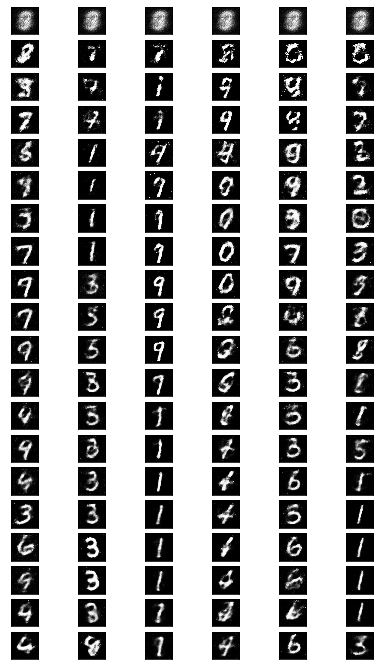

In [12]:
# Xem ảnh sinh giả sau mỗi 20 epochs

rows = 20
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

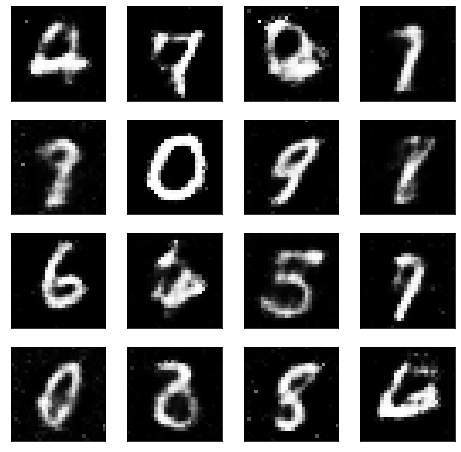

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(8,8), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Lấy mẫu từ file đã lưu
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

#xem kết quả sau khi kết thúc training
view_samples(-1, samples)